In [1]:
import sys
sys.path.append('./src')

import os

import torch
import pandas as pd
import matplotlib.pyplot as plt

from dataset import CausalMNIST
from visualize import visualize_n_digits, boxplot_ead
from utils import set_seed
from train import training, compute_ead

Generating Causal MNIST
Splitting Causal MNIST into train, val and test sets


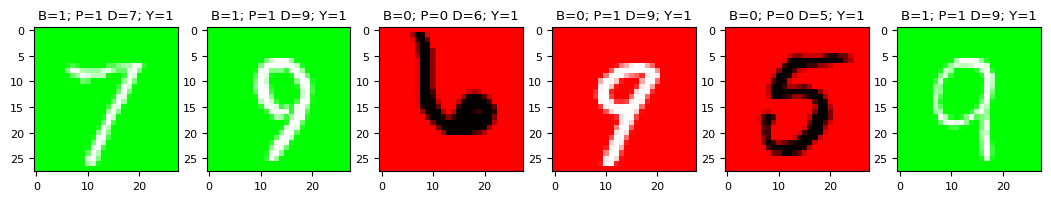

In [3]:
# Load the dataset
subsampling = "biased"
train = CausalMNIST(root='./data', 
                    env='train', 
                    force_generation=True, 
                    force_split=False, 
                    subsampling=subsampling)
visualize_n_digits(train, 6, save=True)

In [ ]:
# Exploratory data analysis
labels = torch.tensor([label for _, label in train.data_label_tuples])
B, P, D, Y = labels[:, 0], labels[:, 1], labels[:, 2], labels[:, 3]

print("Training Set")
print(f'E[D|B=0] = {D[B==0].float().mean()}')
print(f'E[D|B=1] = {D[B==1].float().mean()}')
print(f'E[Y|B=0] = {Y[B==0].float().mean()}')
print(f'E[Y|B=1] = {Y[B==1].float().mean()}')
print(f'EAD = {Y[B==1].float().mean() - Y[B==0].float().mean()}')

# plot the distribution of D given B (no subplot)
fig, ax = plt.subplots()
ax.hist(D[B==0], bins=range(11), alpha=0.5, label=r'$\propto$p(D,B=0)')
ax.hist(D[B==1], bins=range(11), alpha=0.5, label=r'$\propto$p(D,B=1)')
ax.set_xlabel('D')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [ ]:
# Experiment
n_seeds = 100
subsampling = "biased"
verbose = False

results = pd.DataFrame(columns=['dataset', 'seed', 'EAD', 'EAD_prob', 'EAD_binary'])
for seed in range(1, n_seeds+1):
    print(f"Seed {seed}/{n_seeds}")
    set_seed(seed)
    model = training(force_generation=True, 
                  subsampling=subsampling,
                  verbose=verbose)
    train_loader = torch.utils.data.DataLoader(
      CausalMNIST(root='./data', 
                  env='train_full',
                  transform=model.transformations,
                  subsampling=subsampling),
      batch_size=1000, shuffle=False)
    all_loader = torch.utils.data.DataLoader(
      CausalMNIST(root='./data', 
                  env='all',
                  transform=model.transformations,
                  subsampling=subsampling),
      batch_size=1000, shuffle=False)
    
    ead, ead_prob, ead_binary = compute_ead(model, train_loader)
    results.loc[2*seed] = {'dataset': 'train', 'seed': seed, 'EAD': ead.item(), 'EAD_prob': ead_prob.item(), 'EAD_binary': ead_binary.item()}
    ead, ead_prob, ead_binary = compute_ead(model, all_loader)
    results.loc[2*seed+1] = {'dataset': 'all', 'seed': seed, 'EAD': ead.item(), 'EAD_prob': ead_prob.item(), 'EAD_binary': ead_binary.item()}

if not os.path.exists(f'results/CausalMNIST/{subsampling}'):
    os.makedirs(f'results/CausalMNIST/{subsampling}')
results.to_csv(f'results/CausalMNIST/{subsampling}/results.csv', index=False)
boxplot_ead(results, subsampling, save=True)
results

In [ ]:
# load results
subsampling = "random"
results = pd.read_csv(f'results/CausalMNIST/{subsampling}/results.csv')
boxplot_ead(results, subsampling, save=True)